In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, simps
from scipy.interpolate import interp1d

CMB power spectrum

In [2]:
l, dltt, dlee, dlte, _, _ = np.loadtxt("pairwise/camb_data/camb_theory.dat", unpack=True)
cltt = interp1d(l, dltt*2*np.pi/(l*(l+1)), bounds_error=False, fill_value=0)

Beam

In [3]:
ell_th = np.arange(10000)
theta_FWHM = np.radians(5./60)
theta_sigma = theta_FWHM/2.355
bl_th = np.exp(-0.5*theta_sigma**2*ell_th**2)
bl = interp1d(ell_th, bl_th, bounds_error=False, fill_value=0)

Filter

In [4]:
Fl_th = np.load("pairwise/camb_data/Planck_filter_kSZ.npy")
ell = np.load("pairwise/camb_data/Planck_ell_kSZ.npy")
Fl = interp1d(ell, Fl_th, bounds_error=False, fill_value=0)

In [5]:
def fl(l):
    return Fl(l)*bl(l)

Inner integral

In [6]:
def integ_inner(l, L, nphi=64):
    phi = np.linspace(0, np.pi, nphi)
    cphi = np.cos(phi)
    l2 = l**2+L**2+2*l*L*cphi
    l2[l2 <= 0] = 0
    ll = np.sqrt(l2)
    fll = fl(ll)
    return simps(fll*cphi, x=phi)

Outer integral

In [7]:
def get_integ(nll, nphi=64, verbose=False):
    ls = np.linspace(0, 10000, nll)

    # Inner integral
    int1 = np.zeros([nll, nll])
    for i in range(nll):
        if (i % 10 == 0) and verbose:
            print(i)
        for j in range(i, nll):
            ii = integ_inner(ls[i], ls[j], nphi=nphi)
            int1[i, j] = ii
            int1[j, i] = ii
    
    # Outer integral
    integ = simps((ls**2*fl(ls)*cltt(ls))[None, :]*int1, x=ls, axis=-1)
    return ls, integ

1. Compute outer integral (different resolution choices)

In [8]:
ls1, I1 = get_integ(256)

In [9]:
ls2, I2 = get_integ(512)

In [10]:
ls3, I3 = get_integ(1024, nphi=32)

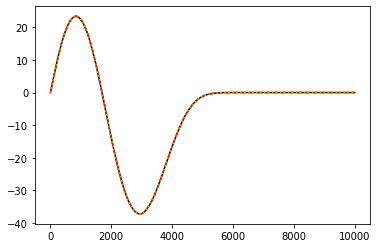

In [11]:
plt.plot(ls1, I1, 'k-')
plt.plot(ls2, I2, 'r--')
plt.plot(ls3, I3, 'y:')

2- Read cross-correlation power spectrum and fit a polynomial to it (in log-log)

In [12]:
import sacc

In [13]:
s = sacc.Sacc.load_fits('../cls_cov_all.fits')
l_s, cl_s, cov_s = s.get_ell_cl('cl_00', 'WISE', 'CMBk', return_cov=True)
err_s = np.sqrt(np.diag(cov_s))
err_s[0] = err_s[1]
coeffs = np.polyfit(np.log(l_s[:-10]), np.log(cl_s[:-10]), w=1/err_s[:-10], deg=6)

def cl_s_fit(ls):
    poly = np.poly1d(coeffs)
    goodl = ls > 0
    cl_out = np.zeros(len(ls))
    cl_out[goodl] = np.exp(poly(np.log(ls[goodl])))
    return cl_out

[]

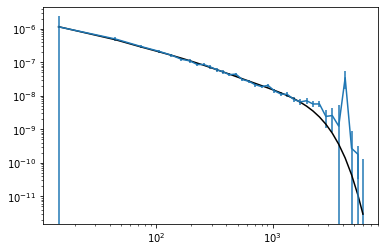

In [14]:
plt.errorbar(l_s, cl_s, yerr=np.sqrt(np.diag(cov_s)))
plt.plot(l_s, cl_s_fit(l_s), 'k-')
plt.loglog()

3- Construct lensing template

In [18]:
Dcl1 = -2*cl_s_fit(ls1)*I1/((2*np.pi)*0.5*(ls1+1))
Dcl2 = -2*cl_s_fit(ls2)*I2/((2*np.pi)*0.5*(ls2+1))
Dcl3 = -2*cl_s_fit(ls3)*I3/((2*np.pi)*0.5*(ls3+1))

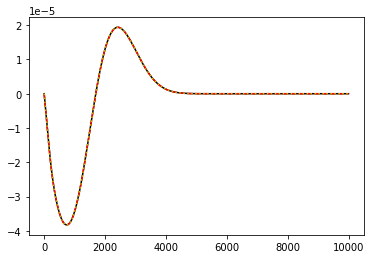

In [19]:
plt.plot(ls1, ls1*(ls1+1)*Dcl1/(2*np.pi), 'k-')
plt.plot(ls2, ls2*(ls2+1)*Dcl2/(2*np.pi), 'r--')
plt.plot(ls3, ls3*(ls3+1)*Dcl3/(2*np.pi), 'y:')

(400.0, 2700.0)

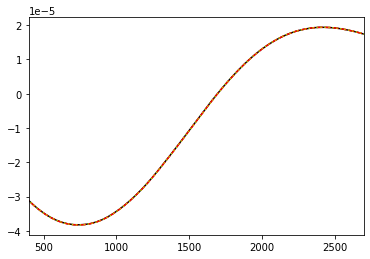

In [20]:
plt.plot(ls1, ls1*(ls1+1)*Dcl1/(2*np.pi), 'k-')
plt.plot(ls2, ls2*(ls2+1)*Dcl2/(2*np.pi), 'r--')
plt.plot(ls3, ls3*(ls3+1)*Dcl3/(2*np.pi), 'y:')
plt.xlim([400, 2700])